In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pickle

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils import data

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
#fast save and retrieve data, no need to read in data again(very slow)

def saveVariables(variables, filename): #where 'variables' is a list of variables
    with open(filename, 'wb+') as file:
        pickle.dump(variables, file)

def retrieveVariables(filename):
    variables = []
    with open(str(filename), 'rb') as file:
        variables = pickle.load(file)
    return variables

In [ ]:
#save and retrieve
#saveVariables([test_envelop_signal ,test_PmP_time, test_PmP_label, test_PmP_dist, test_PmP_evdp], "readindata")

[envelop_signal ,PmP_time, PmP_label, PmP_dist, PmP_evdp, PmP_mag] = retrieveVariables("readindata")
#[envelop_signal, PmP_time, PmP_label, PmP_dist, PmP_evdp, PmP_mag, PmP_stlo, PmP_stla, PmP_evlo, PmP_evla, PmP_evid, PmP_fname] \
#= retrieveVariables("./1995data")

PmP_dist = (np.array(PmP_dist)-40)/150
PmP_evdp = np.array(PmP_evdp)/20

PmP_mag = np.array(PmP_mag)/5
envelop_signal = np.array(envelop_signal)

envelop_signal = preprocessing.normalize(envelop_signal, norm = 'max')
envelop_signal = preprocessing.scale(envelop_signal, axis = 1)

In [8]:
cuda = torch.cuda.is_available()
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
batch_size = 200

In [9]:
#normalize signal. Here we only use envelop. Train test split.
prolong_length = 8

sample_num = len(envelop_signal)
sample_len = len(envelop_signal[0])


X = np.concatenate((envelop_signal, np.ones([sample_num, prolong_length])*PmP_dist[:,np.newaxis],\
                    np.ones([sample_num, prolong_length])*PmP_evdp[:,np.newaxis]), axis = 1)

y = np.concatenate((np.array(PmP_label)[:, np.newaxis], np.array(PmP_time)[:, np.newaxis]), axis=1)


X_train, X_test, y_train, y_test = train_test_split(X[:, np.newaxis], y, test_size=.1, random_state=42)

my_dataset1 = data.TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train).type(torch.float)) # create your training datset
train_loader = data.DataLoader(my_dataset1,batch_size=batch_size, shuffle=True)

my_dataset2 = data.TensorDataset(torch.Tensor(X_test),torch.Tensor(y_test).type(torch.float)) # create your testing datset
test_loader = data.DataLoader(my_dataset2,batch_size=batch_size, shuffle=True)

In [10]:
def pr_curve(p_threshold, model, test_loader):
    model.eval()
    with torch.no_grad():
        TP = np.zeros(len(p_threshold))
        FP = np.zeros(len(p_threshold))
        TN = np.zeros(len(p_threshold))
        FN = np.zeros(len(p_threshold))
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            latents = model.encode(images)
            outputs = model.decode(latents)
            predicted_prob = m(model.predictor(latents)[:, 0])
            for i in range(len(labels)):
                for j in range(len(p_threshold)):
                    if predicted_prob[i] > p_threshold[j]:
                        if labels[i,0] == 1:
                            TP[j] +=1
                        else:
                            FP[j] +=1
                    else:
                        if labels[i,0] ==1:
                            FN[j] +=1
                        else:
                            TN[j] +=1
    precision = (TP+0.01)/(TP+FP+0.01)
    recall = (TP+0.01)/(TP+FN+0.01)
    return [precision, recall]


In [13]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn3 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    
class DecodeBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(DecodeBlock, self).__init__()
        self.t_conv1 = nn.ConvTranspose1d(inplanes, planes, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(True)
        self.t_conv2 = nn.Conv1d(planes, planes, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)

        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        residual = x
        out = self.t_conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.t_conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class PredictorBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(PredictorBlock, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn3 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResnetEncoder(nn.Module):
    
    def __init__(self, encoderblock, decoderblock, predictcorblock, num_blocks, num_outputs):
        self.inplanes = 128
        super(ResnetEncoder, self).__init__()
        self.conv1 = nn.Conv1d(1, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool1d(kernel_size = 2, stride=2, padding=0)
        self.bn1 = nn.BatchNorm1d(self.inplanes)
        
        
        self.avgpool = nn.AvgPool1d(kernel_size = 3, stride=3, padding=0)
        self.layer1 = self._make_layer(encoderblock, self.inplanes, 128, num_blocks[0])
        self.layer2 = self._make_layer(encoderblock, 128, 128, num_blocks[0]) #, stride=2)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(64)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=1, padding=0)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=2, stride=2, padding=0, bias=False)
        
        self.decode_t_conv1 = nn.ConvTranspose1d(64, 64, kernel_size=4, stride=4, padding = 1, bias=False)
        self.decode_bn1 = nn.BatchNorm1d(64)
        self.decode_layer = self._make_layer(decoderblock, 64, 64, num_blocks[1])
        #self.decode_layer2 = self._make_layer(decodeblock, 128, 64, num_blocks[1])
        self.decode_t_conv2 = nn.ConvTranspose1d(64, 128, kernel_size=4, stride=4, padding = 2, bias=False)
        self.decode_bn2 = nn.BatchNorm1d(128)
        self.decode_t_conv3 = nn.ConvTranspose1d(128, 1, kernel_size=3, stride=3, padding = 2, output_padding=1, bias=False)
        
        
        self.predictor_conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.predictor_bn1 = nn.BatchNorm1d(64)
        self.predictor_layer = self._make_layer(predictcorblock, 64, 64, num_blocks[2])
        self.predictor_conv2 = nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.predictor_bn2 = nn.BatchNorm1d(32)
        self.predictor_fc = nn.Linear(in_features=224, out_features=2)
        
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv1d(inplanes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes),
            )
        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        
        for i in range(1, blocks):
            layers.append(block(planes, planes))
        return nn.Sequential(*layers)

    def predictor(self, z):
        z = self.predictor_conv1(z)
        z = self.predictor_bn1(z)
        z = self.relu(z)
        z = self.predictor_layer(z)
        z = self.predictor_conv2(z)
        z = self.predictor_bn2(z)
        z = z.view(z.size(0), -1)
        z = self.predictor_fc(z)
        return z
    
    def decode(self, x):
        x = self.decode_t_conv1(x)
        x = self.decode_bn1(x)
        x = self.relu(x)
        x = self.decode_layer(x)
        #x = self.decode_layer2(x)
        x = self.decode_t_conv2(x)
        x = self.decode_bn2(x)
        x = self.relu(x)
        x = self.decode_t_conv3(x)
        
        return x

    def encode(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.avgpool(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        
        #x = x.view(x.size(0), -1)
        #print(x.shape) 
        return x
    def forward(self, x):
        z = self.encode(x)
        z = self.predictor(z)
        return z

In [14]:
#model definition and training process

model = ResnetEncoder(BasicBlock, DecodeBlock, PredictorBlock, [2, 4, 1], 2)
model.cuda()

num_epochs = 80
learning_rate = 8e-4

m = nn.Sigmoid()
class_weights = torch.FloatTensor([20.]).cuda()
criterion = nn.MSELoss(reduction='mean')
PmPcriterion = torch.nn.BCEWithLogitsLoss(pos_weight = class_weights)
traveltimecriterion = nn.L1Loss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
model.train()
model.zero_grad()
for epoch in range(num_epochs):

    for i, (signals, labels) in enumerate(train_loader):
        signals = signals.to(device)
        labels = labels.to(device)
        
        
        latents = model.encode(signals)
        prediction = model(signals)
        
        outputs = model.decode(latents)
        #loss1: reconstruction loss for autoencoder
        #loss2: PmP label prediction loss, binary cross entropy loss
        #loss3: travel time loss, l1 loss
        loss1 = criterion(outputs, signals)
        loss2 = PmPcriterion(prediction[:,0], labels[:,0])
        loss3 = traveltimecriterion(prediction[:, 1], labels[:, 1])
        loss = loss1 + loss2 + loss3
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 1:
            print ("Epoch [{}/{}], Step [{}/{}] Loss1: {:.6f},Loss2: {:.6f},Loss3: {:.6f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss1.item(),loss2.item(),loss3.item()))
    #Decay learning rate
    if (epoch+1) % 10 == 0:
        curr_lr /= 2
        update_lr(optimizer, curr_lr)
        

Epoch [1/50], Step [1/360] Loss1: 7.525166,Loss2: 2.050906,Loss3: 15.776172
Epoch [1/50], Step [101/360] Loss1: 0.558178,Loss2: 1.534868,Loss3: 8.799536
Epoch [1/50], Step [201/360] Loss1: 0.471311,Loss2: 1.465994,Loss3: 6.233334
Epoch [1/50], Step [301/360] Loss1: 0.418711,Loss2: 1.394074,Loss3: 3.713629
Epoch [2/50], Step [1/360] Loss1: 0.405847,Loss2: 0.789292,Loss3: 2.781152
Epoch [2/50], Step [101/360] Loss1: 0.391852,Loss2: 0.858283,Loss3: 0.996763
Epoch [2/50], Step [201/360] Loss1: 0.372493,Loss2: 0.629007,Loss3: 0.638756
Epoch [2/50], Step [301/360] Loss1: 0.367532,Loss2: 1.051935,Loss3: 0.573111
Epoch [3/50], Step [1/360] Loss1: 0.354073,Loss2: 1.436056,Loss3: 0.564688
Epoch [3/50], Step [101/360] Loss1: 0.341230,Loss2: 0.539790,Loss3: 0.480865


KeyboardInterrupt: 

In [26]:
#model evaluation on new test set


predicted_PmPlabel = torch.tensor([]).cuda()
true_PmPlabel = torch.tensor([]).cuda()
predicted_traveltime = torch.tensor([]).cuda()
true_traveltime = torch.tensor([]).cuda()
labelloss = torch.tensor([]).cuda()
traveltimeloss = torch.tensor([]).cuda()
m = nn.Sigmoid()

recovered_signal = torch.tensor([]).cuda()
original_signal = torch.tensor([]).cuda()
recovered_dist = torch.tensor([]).cuda()
original_dist = torch.tensor([]).cuda()
recovered_evdp = torch.tensor([]).cuda()
original_evdp = torch.tensor([]).cuda()

model.eval()
with torch.no_grad():
    for signals, labels in test_loader:
        signals = signals.to(device)
        labels = labels.to(device)
        #dist_evdp = images[:, -(prolong_length*2+1):-1]
        latents = model.encode(signals)
        prediction = model(signals)
        probability = m(prediction[:,0])
        outputs = model.decode(latents).squeeze()

        recovered_signal = torch.cat([recovered_signal, outputs[:, :281]])
        recovered_dist = torch.cat([recovered_dist, outputs[:, 282]*150+40])
        recovered_evdp = torch.cat([recovered_evdp, outputs[:, -1]*20])
        original_signal = torch.cat([original_signal, signals[:, 0, :281]])
        original_dist = torch.cat([original_dist, signals[:, 0, 282]*150+40])
        original_evdp = torch.cat([original_evdp, signals[:, 0, -1]*20])
        predicted_PmPlabel = torch.cat([predicted_PmPlabel, probability])
        true_PmPlabel = torch.cat([true_PmPlabel, labels[:, 0].float()])
        labelloss = torch.cat([labelloss, PmPcriterion(probability, labels[:,0]).view(1)])

        
        traveltimeloss = torch.cat([traveltimeloss, torch.abs(prediction[:,1] - labels[:, 1])])
        predicted_traveltime = torch.cat([predicted_traveltime, prediction[:, 1]])
        true_traveltime = torch.cat([true_traveltime, labels[:, 1]])

        #print(predicted_prob[:,1].shape)

In [27]:
torch.mean(labelloss)

tensor(0.7799, device='cuda:0')

In [28]:
traveltimeloss
torch.mean(traveltimeloss)

tensor(16.3532, device='cuda:0')

In [29]:
predicted_traveltime

tensor([14.2974, 16.5640, 20.2528,  ..., 16.5078,  8.4850, 12.7240],
       device='cuda:0')

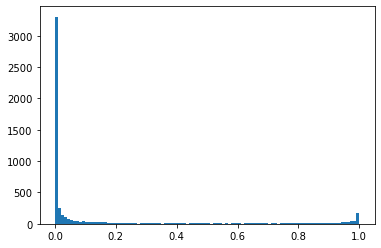

tensor([1.4430e-05, 8.9883e-01, 3.6096e-01,  ..., 5.2595e-02, 6.8393e-01,
        2.0779e-04], device='cuda:0')

In [30]:
plt.hist(predicted_PmPlabel.cpu().numpy(),bins = 100)
plt.show()

predicted_PmPlabel

In [31]:
true_PmPlabel

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [32]:
print(torch.max(torch.abs(traveltimeloss)))
print(torch.min(predicted_traveltime))
print(torch.max(predicted_traveltime))

tensor(31.4501, device='cuda:0')
tensor(7.2961, device='cuda:0')
tensor(31.4501, device='cuda:0')


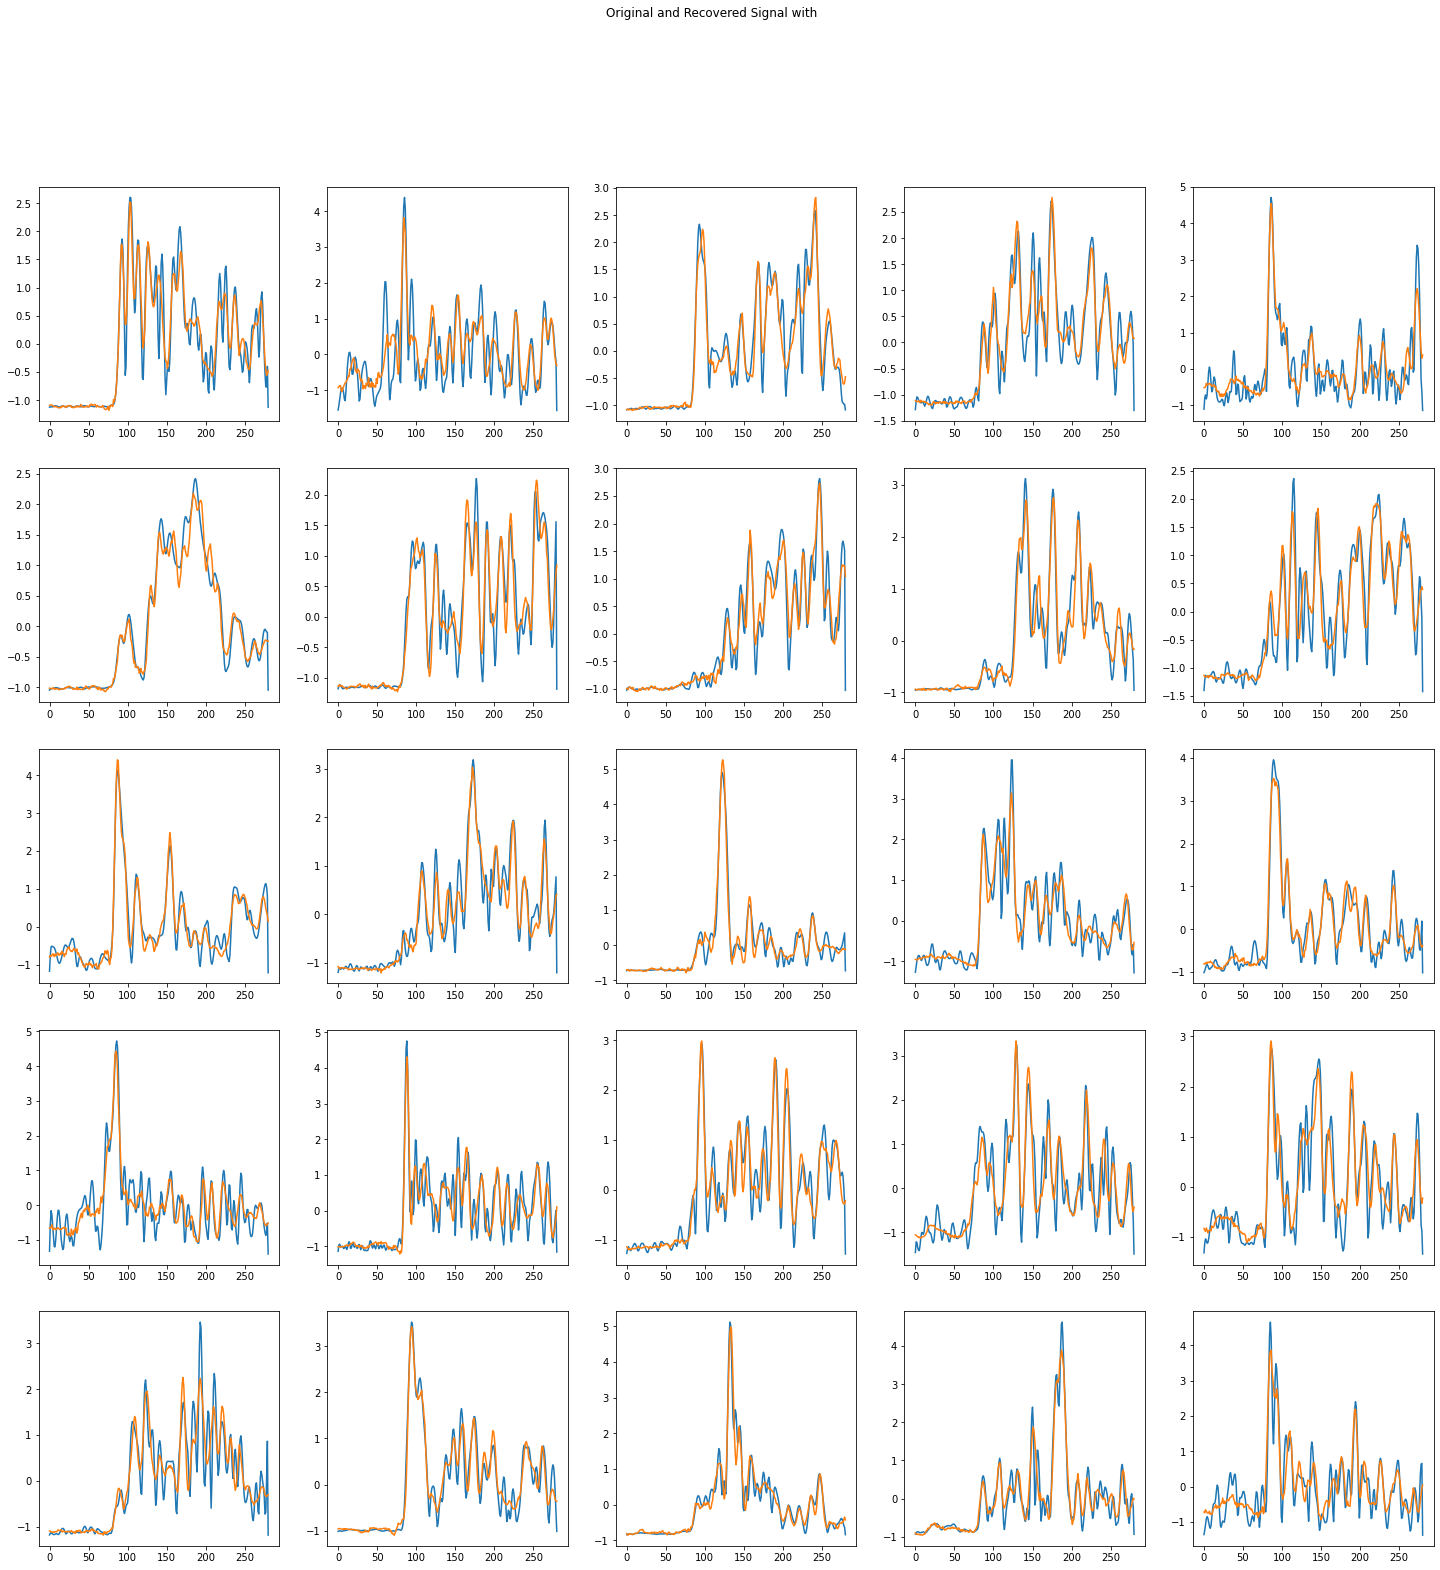

In [36]:
fig, axs = plt.subplots(5,5)
fig.suptitle('Original and Recovered Signal with ')
fig.set_figheight(25)
fig.set_figwidth(25)
np.random.random
for i in range(5):
    for j in range(5):
        index = np.random.randint(len(original_signal))
        axs[i, j].plot(original_signal[index].detach().cpu().numpy(), label = "original signal")
        axs[i, j].plot(recovered_signal[index].detach().cpu().numpy(), label = "recovered signal")



#plt.plot(original_signal[i].detach().cpu().numpy(), label = "original signal")
#plt.plot(recovered_signal[i].detach().cpu().numpy(), label = "recovered signal")
#plt.legend(loc='upper left',bbox_to_anchor=(3,10))
plt.show()

In [22]:
p_threshold = np.array([1e-1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,0.95,0.99, 0.999])
pr_curve2 = np.asarray(pr_curve(p_threshold, model, test_loader))
pr_curve2

array([[0.43176243, 0.50000524, 0.53988971, 0.57553589, 0.62125857,
        0.65979882, 0.70607498, 0.75267344, 0.81637093, 0.87414476,
        0.95316933, 0.97931106],
       [0.91148943, 0.898307  , 0.87947496, 0.86817574, 0.85875972,
        0.84369409, 0.83239487, 0.796614  , 0.77024915, 0.71940265,
        0.65160731, 0.53484868]])

In [23]:
checkpoint = {'model': model.state_dict()}
torch.save(checkpoint, 'checkpoint_PmPNet.pth')

In [50]:

model = ResnetEncoder(BasicBlock, DecodeBlock, PredictorBlock, [2, 4, 1], 2)

model.load_state_dict(torch.load('checkpoint_PmPNet.pth')['model']);
model.cuda();

learning_rate = 8e-4
class_weights = torch.FloatTensor([20.]).cuda()
criterion = nn.L1Loss(reduction='mean')
PmPcriterion = torch.nn.BCEWithLogitsLoss(pos_weight = class_weights)
traveltimecriterion = nn.L1Loss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)